# AF/PW Ghana Communities

Notebook to provide filtering and merging of communities and settlements data from GRID3 Settlements Extents and UN OCHA's COD-PP Dataset

Done per-region. A region name/code is immediately applied to the Settlement Extents data to pare down for quicker/easier processing.

In [1]:
import os
import geopy
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.express as px

from tqdm.notebook import tqdm
from geopy.distance import distance, lonlat

In [2]:
# se_sample_file = "/Users/datascience/Downloads/gh_se_sample.geojson"
# sample_df = gpd.read_file(se_sample_file)
# sample_df.shape
# sample_df.info()
# sample_df["geometry"].iloc[0]

<h2 style="padding:7px; color:gainsboro; background-color:coral;">CONFIG</h2>

In [3]:
# Settlement Extents file
se_file = "/Users/datascience/Data/Ghana_Settlement_Extents_Version_01.01.geojson"

# Populated Places stats file
pp_file = "/Users/datascience/Data/UN OCHA - COD-PP - gha_ppl_1m_nga.zip"

In [55]:
# Regions and Select region
regions_pcodes = {
    "Ashanti": "GH02",
    "Eastern": "GH06",
    "Volta": "GH14",
    "Bono": "GH03",
    "Ahafo": "GH01"
}

sel_region = "Ahafo"

In [56]:
# Population range. NB: applied to UN-adjusted population
pop_min = 1000
pop_max = 20000

In [57]:
# Export filenames
base_dir = "/Users/datascience/Development/aquaya/py-sandbox/assurance-fund/data/"
export_pref = os.path.join(base_dir, f"AFPW-GHA-Communities-{sel_region}.{pop_min}-{pop_max}")

export_pref

'/Users/datascience/Development/aquaya/py-sandbox/assurance-fund/data/AFPW-GHA-Communities-Ahafo.1000-20000'

<h2 style="padding:7px; color:gainsboro; background-color:coral;">LOAD SOURCE DATA</h2>

In [7]:
se_df = gpd.read_file(se_file, iterator=True, chunksize=1000, index="OBJECTID")
se_df.shape

(374257, 16)

In [8]:
se_df = se_df.dropna(subset=["population", "geometry", "adm1_pcode"])
se_df.shape

(372504, 16)

In [9]:
pp_df = gpd.read_file(pp_file)
pp_df.shape

(11439, 18)

<h2 style="padding:7px; color:gainsboro; background-color:coral;">FILTER AND CLEAN</h2>

- Filter to selected region
- Filter to selected population range

> generate `comms_df` of communities data in selected region

In [58]:
# Report number of settlements per region
se_df["adm1_name"].value_counts()

adm1_name
Ashanti             53092
Northern            39588
Western North       38623
Western             32902
Eastern             27267
Bono East           25245
Upper West          24598
Upper East          18928
Central             18165
Savannah            17567
Ahafo               17137
Bono                15404
Oti                 13981
Volta               13247
Northern East       12354
Greater Accra        4126
crosses boundary      165
NA                    115
Name: count, dtype: int64

In [59]:
# Filter to single-region dataframe
# NB: We are filtering out any communities here that cross region boundaries or have null name (~165 + 115 re: value counts above). 
reg_se_df = se_df[se_df["adm1_name"] == sel_region].copy()
reg_se_df = reg_se_df.set_index("OBJECTID")
reg_se_df.shape

(17137, 15)

In [60]:
# Sanity check against pcode: All region entries should have name corresponding to pcode
assert (~(reg_se_df["adm1_pcode"] == regions_pcodes[sel_region])).sum() == 0, "Double check region name, pcode, and data"

# Sanity check: Also confirm the number of settlements for selected region above (from `.value_counts()`) is the same as shape here
# EG: Bono should have 15,404 settlements

In [61]:
reg_se_df.head(2)

,mgrs_code,country,iso,type,population,pop_un_adj,adm0_pcode,adm1_name,adm1_pcode,adm2_name,adm2_pcode,settl_pcode,Shape__Area,Shape__Length,geometry
OBJECTID,,,,,,,,,,,,,,,
84836,30NWN2167_01,Ghana,GHA,Built-up Area,3726.278803,3504.478940,GH,Ahafo,GH01,Asunafo North Municipal,GH0101,GH0101000001,0.000131,0.069264,"POLYGON ((-2.81143 6.94816, -2.81090 6.94784, ..."
84837,30NWN4940_02,Ghana,GHA,Built-up Area,6285.133574,5911.022605,GH,Ahafo,GH01,Asunafo North Municipal,GH0101,GH0101000002,0.000208,0.103293,"POLYGON ((-2.55509 6.70605, -2.55502 6.70454, ..."


In [62]:
# Filter settlements to population range -> Create "communities" dataframe
# NB: We can use raw GRID3 population estimate ('population') or UN-adjusted population estimate ('pop_un_adj') here. Preference is for latter.
comms_df = reg_se_df[reg_se_df["pop_un_adj"].between(pop_min, pop_max, inclusive="both")].copy()
# del(reg_se_df)
comms_df.shape

(38, 15)

<h2 style="padding:7px; color:gainsboro; background-color:coral;">EXPLORE</h2>

<Axes: >

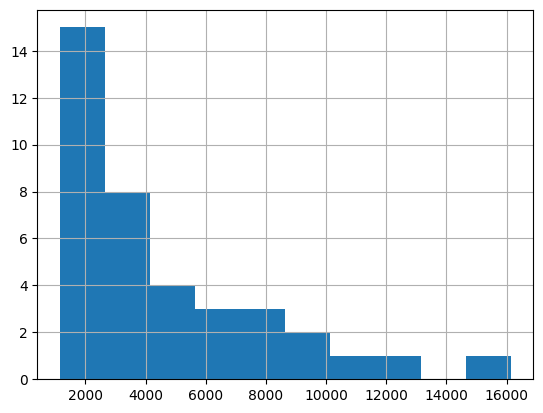

In [63]:
# Basic hist of population count
comms_df["population"].hist()

In [64]:
fmap = comms_df.explore(tiles="CartoDB positron", width=1200)
fmap

<h2 style="padding:7px; color:gainsboro; background-color:coral;">ANNOTATE</h2>

<h3 style="padding:5px; color:gainsboro; background-color:cornflowerblue;">Add single representative "center" point of each shape</h3>

In [65]:
# Ignore warnings - visually analyzing centers shows they are fine. NB: Not always inside settlement shapes. Alternatively can use 'GeoSeries.representative_point'
comms_df["approx_center_lat"] = comms_df["geometry"].centroid.y
comms_df["approx_center_lon"] = comms_df["geometry"].centroid.x

/var/folders/_f/bhtpz1nj0216d4sgdjmd9vk40000gn/T/ipykernel_38698/175070365.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  comms_df["approx_center_lat"] = comms_df["geometry"].centroid.y
/var/folders/_f/bhtpz1nj0216d4sgdjmd9vk40000gn/T/ipykernel_38698/175070365.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  comms_df["approx_center_lon"] = comms_df["geometry"].centroid.x


In [66]:
comms_df.head(2)

,mgrs_code,country,iso,type,population,pop_un_adj,adm0_pcode,adm1_name,adm1_pcode,adm2_name,adm2_pcode,settl_pcode,Shape__Area,Shape__Length,geometry,approx_center_lat,approx_center_lon
OBJECTID,,,,,,,,,,,,,,,,,
84836,30NWN2167_01,Ghana,GHA,Built-up Area,3726.278803,3504.478940,GH,Ahafo,GH01,Asunafo North Municipal,GH0101,GH0101000001,0.000131,0.069264,"POLYGON ((-2.81143 6.94816, -2.81090 6.94784, ...",6.943226,-2.806746
84837,30NWN4940_02,Ghana,GHA,Built-up Area,6285.133574,5911.022605,GH,Ahafo,GH01,Asunafo North Municipal,GH0101,GH0101000002,0.000208,0.103293,"POLYGON ((-2.55509 6.70605, -2.55502 6.70454, ...",6.696384,-2.553219


<h3 style="padding:5px; color:gainsboro; background-color:cornflowerblue;">Filter UN COD-PP Data, attempt to assign to settlements</h3>

Data to add:
- Lat/lon (compare to center)
- NAME, REFNAME
- popPlace1 - Place type indicator from UN. Only input is for capitals (district, regional, national)

In [67]:
reg_pp_df = pp_df[pp_df["ADM1_EN"] == sel_region].copy()
assert (reg_pp_df["ADM1_PCODE"] != regions_pcodes[sel_region]).sum() == 0, "Region name - PCode or data mismatch"
reg_pp_df.shape

(78, 18)

In [68]:
reg_pp_df.head(2)

,LAT,LONG,CNTRY_CODE,NAME,REFNAME,Pcod,popPlaceCI,popPlace1,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry
6140,6.483333,-2.433333,GHA,Pafu,None,GH01020001,0.0,Other,Asunafo South,GH0102,Ahafo,GH01,Ghana,GH,2018-10-26,2021-03-08,None,POINT (-2.43333 6.48333)
6192,6.500000,-2.500000,GHA,Sankori,None,GH01020001,0.0,Other,Asunafo South,GH0102,Ahafo,GH01,Ghana,GH,2018-10-26,2021-03-08,None,POINT (-2.50000 6.50000)


In [69]:
reg_pp_df.explore(m=fmap, color="magenta")

In [70]:
# F.E. community, find closest UN Ocha settlement
dist_thresh_km = 10.0

for r in comms_df.itertuples():
    min_dist_row = None
    min_dist = dist_thresh_km
    for s in reg_pp_df.itertuples():
        d = distance((r.approx_center_lat, r.approx_center_lon), (s.LAT, s.LONG))
        if d < min_dist:
            min_dist = d
            min_dist_row = s
    if min_dist_row is None:
        print(f"No min dist under threshold for {r.Index}")
    else:
        comms_df.at[r.Index, "UN_CommunityName"] = min_dist_row.NAME
        comms_df.at[r.Index, "UN_RefName"] = min_dist_row.REFNAME
        comms_df.at[r.Index, "UN_PopPlaceType"] = min_dist_row.popPlace1
        comms_df.at[r.Index, "UN_Lat"] = min_dist_row.LAT
        comms_df.at[r.Index, "UN_Lon"] = min_dist_row.LONG

No min dist under threshold for 84836


In [71]:
# Move geometry column to the back
comms_df["geometry"] = comms_df.pop("geometry")

<h2 style="padding:7px; color:gainsboro; background-color:coral;">EXPLORE ANNOTATED COMMUNITIES DATA</h2>

In [72]:
comms_df.head(2)

,mgrs_code,country,iso,type,population,pop_un_adj,adm0_pcode,adm1_name,adm1_pcode,adm2_name,...,Shape__Area,Shape__Length,approx_center_lat,approx_center_lon,UN_CommunityName,UN_RefName,UN_PopPlaceType,UN_Lat,UN_Lon,geometry
OBJECTID,,,,,,,,,,,,,,,,,,,,,
84836,30NWN2167_01,Ghana,GHA,Built-up Area,3726.278803,3504.478940,GH,Ahafo,GH01,Asunafo North Municipal,...,0.000131,0.069264,6.943226,-2.806746,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-2.81143 6.94816, -2.81090 6.94784, ..."
84837,30NWN4940_02,Ghana,GHA,Built-up Area,6285.133574,5911.022605,GH,Ahafo,GH01,Asunafo North Municipal,...,0.000208,0.103293,6.696384,-2.553219,Akrodie,None,Town,6.7,-2.55,"POLYGON ((-2.55509 6.70605, -2.55502 6.70454, ..."


In [73]:
comms_df.explore(tiles="CartoDB positron", width="75%")

<h2 style="padding:7px; color:gainsboro; background-color:coral;">EXPORT</h2>

In [74]:
export_pref

'/Users/datascience/Development/aquaya/py-sandbox/assurance-fund/data/AFPW-GHA-Communities-Ahafo.1000-20000'

In [75]:
comms_df.to_file(export_pref + ".geojson")

In [76]:
pd.DataFrame(comms_df.drop(columns=["geometry", "mgrs_code"])).to_excel(export_pref + ".summary.xlsx", index=False)